# Analysis of flagged purification policies

In [1]:
import numpy as np
import math
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn
from scipy.optimize import fsolve

import main_1GnB as main

---
---
## AF plot

In [12]:
n = 10

# GEN
p_gen = 0.5
F_new = 0.9
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
q_purif = np.linspace(0,1,50)
pur_after_swap = False

# NOISE
Gamma = 0.02

# CONS
p_cons = 0.1

# Experiment
policy_names = ['DEJMPS + Repl.', 'DEJMPS + Repl. (flagged)']
varying_param = 'q_purif'
savefig = False

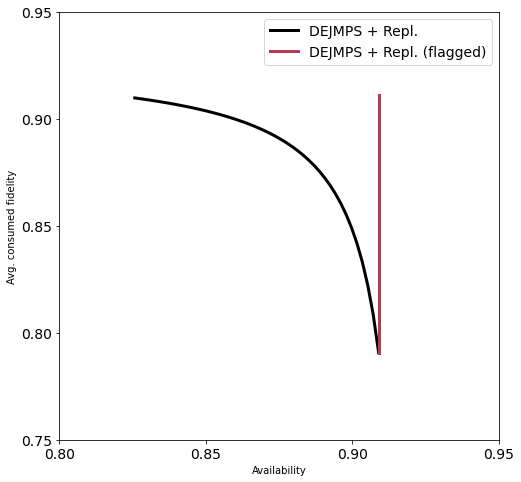

In [13]:
imp.reload(main)

main.AFplot_theory(varying_param, n, p_gen, rho_new, q_purif, policy_names,
                      pur_after_swap, Gamma, p_cons, savefig=False, xlims=None, ylims=None)

In [14]:
main.AFplot_interactive(policy_names)

interactive(children=(IntSlider(value=1, description='n', layout=Layout(width='60%'), max=15, min=1), FloatSli…

---
---
## Difference in max F ($q=1$) and A

In [4]:
n = 2

# GEN
p_gen = 1
F_new = 0.7
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
q_purif = 1
pur_after_swap = False

# NOISE
Gamma = 0.01

# CONS
p_cons = 0.1

# Experiment
policy_names = ['DEJMPS + Repl.', 'DEJMPS + Repl. (flagged)']
#varying_param = 'F_new'
#varying_array = np.linspace(0.5,1,50)
varying_param = 'Gamma'
varying_array = np.logspace(-3,1,50)
colors = ['k', 'tab:orange']
linestyles = ['-', '--']
savefig = True

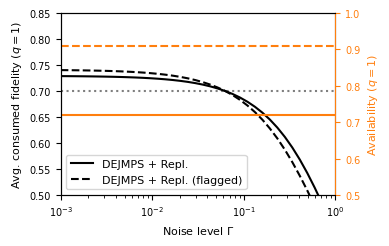

In [12]:
## THEORY ##

imp.reload(main)

Fcons_vecs = [[None for _ in varying_array] for policy in policy_names]
A_vecs = [[None for _ in varying_array] for policy in policy_names]

for idx_policy, policy_name in enumerate(policy_names):
    purif_policy = main.policy_label_to_function(policy_name)
    
    for idx_varying, varying_value in enumerate(varying_array):
        if varying_param=='Gamma':
            Gamma = varying_value
        elif varying_param=='F_new':
            F_new = varying_value
            rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])
        else:
            raise ValueError('Unknown varying_param')
    
        A, Fcons = main.analytical_availability_Fcons(n, p_gen, rho_new, q_purif,
                                                      purif_policy, pur_after_swap, Gamma, p_cons)
        Fcons_vecs[idx_policy][idx_varying] = Fcons
        A_vecs[idx_policy][idx_varying] = A


## PLOT ##
xfig = 9 # cm
yfig = 6 # cm
fontsize_labels = 8

# Plot
fig, ax1 = plt.subplots(figsize=(xfig/2.54, yfig/2.54))
ax2 = ax1.twinx()

for idx_policy, policy_name in enumerate(policy_names):
    ax1.plot(varying_array, Fcons_vecs[idx_policy], linestyle=linestyles[idx_policy],
             color=colors[0], label=policy_name)
if varying_param=='Gamma':
    ax1.plot([varying_array[0], varying_array[-1]], [F_new,F_new], linestyle=':', color=colors[0], alpha=0.5)
elif varying_param=='F_new':
    ax1.plot([0,1], [0,1], linestyle=':', color=colors[0], alpha=0.5)
    
for idx_policy, policy_name in enumerate(policy_names):
    ax2.plot(varying_array, A_vecs[idx_policy], linestyle=linestyles[idx_policy],
             color=colors[1], label=policy_name)

# Plot specs
ax1.set_xlim([varying_array[0],1])#varying_array[-1]])
ax1.set_ylim([0.5,0.85])
ax2.set_ylim([0.5,1])
if varying_param=='Gamma':
    ax2.set_xscale('log')
if varying_param=='Gamma':
    ax1.set_xlabel(r'Noise level $\Gamma$', fontsize=fontsize_labels)
elif varying_param=='F_new':
    ax1.set_xlabel(r'Fidelity of new links $F_\mathrm{new}$', fontsize=fontsize_labels)
else:
    raise ValueError('Unknown varying_param')
ax1.set_ylabel(r'Avg. consumed fidelity ($q=1$)', fontsize=fontsize_labels)
ax2.set_ylabel(r'Availability ($q=1$)', color=colors[1], fontsize=fontsize_labels)
ax1.tick_params(labelsize=fontsize_labels-1)
ax2.spines['right'].set_color(colors[1]) # Axis
ax2.tick_params(axis='y', which='both', colors=colors[1], labelsize=fontsize_labels-1) # Ticks

ax1.legend(loc='lower left', fontsize=fontsize_labels)

if savefig:
    if varying_param=='Gamma':
        filename = 'figs/flags-q%.3f-n%d-pg%.3f-Fnew%.3f-pc%.3f.pdf'%(q_purif,
                    n, p_gen, F_new, p_cons)
    elif varying_param=='F_new':
        filename = 'figs/flags-q%.3f-n%d-pg%.3f-Gamma%.3f-pc%.3f.pdf'%(q_purif,
                    n, p_gen, Gamma, p_cons)
    else:
        raise ValueError('Unknown varying_param')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
else:
    plt.show()

---
### CONCLUSIONS:
 1. Incorporating intermediate flags to the protocol always increases the availability.
 2. When there is strong noise, the flagged protocol delivers a lower avg. consumed fidelity.
 3. When the level of noise is below some threshold, the flagged protocol increases the avg. consumed fidelity.
 4. The threshold seems to happen for $\Gamma$ such that $\overline F_\mathrm{cons} = F_\mathrm{new}$ (I tested for different values of the parameters and I always observed the same thing). I am puzzled by this!
 
If one needs to boost the availability, flags can definitely help. However, they can also reduce the avg. consumed fidelity in some regimes, so one should be careful with that.

---
---
## Probability of success and jump function

In [106]:
policy_names = ['DEJMPS + Repl.', 'DEJMPS + Repl. (flagged)']

main.policies_plot_interactive(policy_names)

interactive(children=(IntSlider(value=1, description='num_new_links', layout=Layout(width='60%'), max=15, min=…